In [1]:
def generate_conversion_rate(prices):
    val = np.random.uniform(size=(len(prices)))
    conversion_rates = np.sort(val)[::-1]
    return conversion_rates

In [2]:
import matplotlib.pyplot as plt
from mab.environment import *
from mab.ts_learner import *
from mab.ucb_learner import *

#Customers
customerParams = zip([200,200,200,200], [50,50,50,50])
#discounts
discounts = np.array([0.0, 0.5, 0.10, 0.25])
#Conversion Rates for item 2 [discountedPrice x Class]
conv_rate2 = np.array([[0.1, 0.2, 0.15, 0.2],
                    [0.15, 0.25, 0.2, 0.25],
                    [0.2, 0.35, 0.25, 0.4],
                    [0.4, 0.45, 0.35, 0.6]])
                    
prices = [500, 690, 750, 850, 900]
n_classes = 4

#T = 300

conv_rate1 = generate_conversion_rate(prices)
n_customers =  [100,100,100,100]
 
max_conv = np.argmax(conv_rate1)

opt = conv_rate1[max_conv]
print(opt)

0.9982174959038542


In [3]:
n_experiments = 200
ts_rewards_per_experiment = np.zeros([n_classes , n_customers[1]])
u_rewards_per_experiment = np.zeros([n_classes , n_customers[1]])

customerParams = zip([200,200,200,200], [50,50,50,50])
env = Environment(customerParams, discounts, prices, conv_rate1, conv_rate2)
ts_learner =TS_Learner(arms=prices)      
u_learner = UCB(n_arms=len(prices))
for c in range(n_classes):
    for customer in range(n_customers[c]):
        arms = prices  # +constant second item 
        pulled_arm = ts_learner.pull_arm()
        reward = env.round_1(pulled_arm)
        ts_learner.update(pulled_arm,reward,c)

        pulled_arm = u_learner.pull_arm()
        reward = env.round_1(pulled_arm)
        u_learner.update(pulled_arm,reward,c)
        
        ts_rewards_per_experiment[c][customer] = ts_learner.rewards_per_arm[c]
        u_learner_per_experiment[c][customer] = u_learner.rewards_per_arm[c]

        #we wanted to do as before, using customers instead of days, but for some reason it wouldn't work.
        #Maybe we have to update this only once for class? But in this way the cumulative sum for each class does not make sense.

ValueError: setting an array element with a sequence.

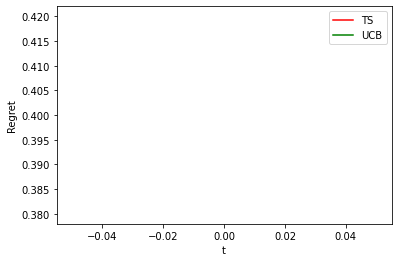

In [4]:
cust_class = 0
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.mean(ts_rewards_per_experiment[cust_class], axis=0), 'r')
plt.plot(np.mean(u_rewards_per_experiment[cust_class], axis=0), 'g')
plt.legend(["TS", "UCB"])
plt.show()